##Importing Packages and Data

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sea
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
from sklearn.preprocessing import LabelEncoder
from keras.layers import Concatenate
from keras.layers.merge import concatenate
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Input
from keras.applications.nasnet import NASNetLarge


# Multiple Inputs
from keras.utils import plot_model
from keras.models import Model

from keras.optimizers import Adam

In [ ]:
tf.test.gpu_device_name()

''

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adhirajroka","key":"32027bd612c6093e640cbd5f0fac15ea"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/rsna-bone-age

100% 9.28G/9.29G [03:34<00:00, 85.7MB/s]
100% 9.29G/9.29G [03:34<00:00, 46.4MB/s]


In [ ]:
!unzip rsna-bone-age.zip

In [ ]:
!rm rsna-bone-age.zip

In [ ]:
train_df= pd.read_csv("/content/boneage-training-dataset.csv")
print("Glimpse")
print(train_df.head())

#Check Missing values:#
print("\n")
print("Check missing values")
pd.DataFrame(train_df.isnull().sum(), columns=["NA's"])
#No missing values

Glimpse
     id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False


Check missing values


,NA's
id,0
boneage,0
male,0


In [ ]:
train_df["gender"]= train_df["male"].apply(lambda x:"male" if x else "female")
print(train_df.head())

test_df = pd.read_csv('boneage-test-dataset.csv')

train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 

print(test_df.head())

     id  boneage   male  gender
0  1377      180  False  female
1  1378       12  False  female
2  1379       94  False  female
3  1380      120   True    male
4  1381       82  False  female
    Case ID Sex
0  4360.png   M
1  4361.png   M
2  4362.png   M
3  4363.png   M
4  4364.png   M


##Exploratory Data Analysis (EDA)

Summary
            boneage
count  12611.000000
mean     127.320752
std       41.182021
min        1.000000
25%       96.000000
50%      132.000000
75%      156.000000
max      228.000000




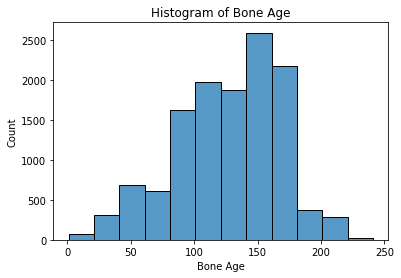

In [ ]:
print("Summary")
print(train_df.describe())

sea.histplot(data=train_df["boneage"],binwidth=20)

print("\n")
plt.xlabel("Bone Age")
plt.title('Histogram of Bone Age')
plt.show()


In [ ]:
#Per gender group hist()
sea.displot(train_df, x="boneage", col="gender", multiple="dodge", hue="gender",binwidth=15,palette="Set1")
plt.show()


In [ ]:
sea.countplot(x="gender",data=train_df, palette="Set1")
plt.title("Barplot of Gender")
plt.show()

In [ ]:
sea.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sea.violinplot(x='gender', y='boneage', data=train_df, kind="box", palette="Set1",ax=ax)
plt.title("Violin Plot of BoneAge vs. Gender")
plt.show()

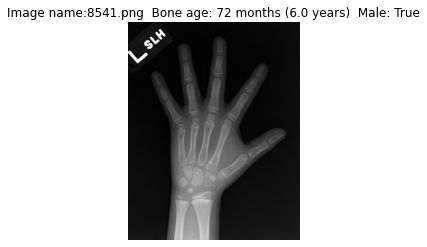

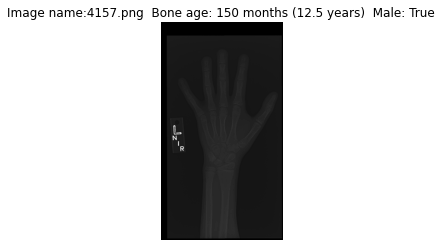

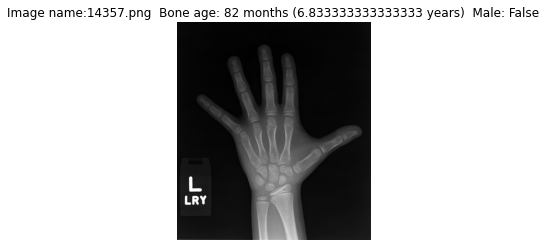

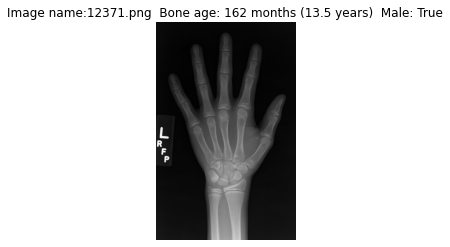

In [ ]:
import matplotlib.image as mpimg
for filename, boneage, male in train_df[['id','boneage','male']].sample(4).values:
    img = mpimg.imread('boneage-training-dataset/boneage-training-dataset/'+ filename)
    plt.imshow(img, cmap = 'gray')
    plt.title('Image name:{}  Bone age: {} months ({} years)  Male: {}'.format(filename, boneage, boneage/12, male))
    plt.axis('off')
    plt.show()

##Subsampling Data

In [ ]:
np.random.seed(222)
tdf=train_df.groupby('gender', group_keys=False).apply(lambda x: x.sample(2250))

print(train_df)

print(tdf)

              id  boneage   male  gender
0       1377.png      180  False  female
1       1378.png       12  False  female
2       1379.png       94  False  female
3       1380.png      120   True    male
4       1381.png       82  False  female
...          ...      ...    ...     ...
12606  15605.png       50  False  female
12607  15606.png      113  False  female
12608  15608.png       55  False  female
12609  15609.png      150   True    male
12610  15610.png      132   True    male

[12611 rows x 4 columns]
              id  boneage   male  gender
10401  13137.png      132  False  female
5034    7153.png      180  False  female
828     2300.png      132  False  female
9124   11721.png       94  False  female
10560  13321.png      144  False  female
...          ...      ...    ...     ...
8856   11416.png       32   True    male
5516    7690.png      162   True    male
5837    8052.png       21   True    male
8499   11006.png      120   True    male
12391  15361.png       72   Tru

#Model 1 - CNN

####Data Prepocessing

In [ ]:
datagen= ImageDataGenerator( rescale=1./255,
                                  shear_range=0.2,
                                  rotation_range=20,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip = True,
                                  validation_split=0.2)#split into train/val
train_set=datagen.flow_from_dataframe(dataframe =tdf,
    directory='/content/boneage-training-dataset/boneage-training-dataset',
    x_col="id",
    y_col="boneage",
    subset="training",
    target_size=(64,64),
    batch_size=32,
    class_mode= 'raw',
    seed=2)

validation_set=datagen.flow_from_dataframe(dataframe =tdf,
    directory='/content/boneage-training-dataset/boneage-training-dataset',
    x_col="id",
    y_col="boneage",
    subset="validation",
    target_size=(64,64),
    batch_size=32,
    class_mode= 'raw',
    seed=2)

test_datagen= ImageDataGenerator(rescale=1./255)

test_set=test_datagen.flow_from_dataframe(dataframe=test_df,                                 
    directory='/content/boneage-test-dataset/boneage-test-dataset',
    x_col="Case ID",
    y_col=None,
    target_size=(64,64),
    batch_size=32,
    class_mode=None,
    seed=2)

Found 3600 validated image filenames.
Found 900 validated image filenames.
Found 200 validated image filenames.


In [ ]:
# fnames_train = pd.DataFrame({'id':train_set.filenames})
# tdf_pd = pd.DataFrame(tdf)
# #print(fnames_train[0:10])
# print("Size of filenames df =", fnames_train.shape[0])

# train_vars = fnames_train.merge(tdf_pd, how='left', left_on='id', right_on='id')
# #print(train_vars[0:10])

# train_gender = train_vars[['id','gender']]
# #print(" ")
# #print("Sample of merged dataset - gender for training set:")
# #print(train_gender[0:10])
# #print(train_gender.shape)

# print(" ")
# print("Counts of gender in training set:")
# print(train_gender['gender'].value_counts())

# fnames_validation = np.array(validation_set.filenames)
# #print(fnames_validation.shape)



###Build CNN

In [ ]:
tf.random.set_seed(321)

cnn=Sequential()

cnn.add(Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=[64,64,3]))
cnn.add(MaxPooling2D(pool_size=2,strides=2))

cnn.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
cnn.add(MaxPooling2D(pool_size=2,strides=2))

cnn.add(Flatten())
cnn.add(Dense(units=128,activation='relu'))  #Full Connection

cnn.add(Dense(units=1,activation='linear')) #output layer

#Compile#

cnn.compile(optimizer='adam',loss='mean_squared_error', metrics=["mae"])

#Fit
cnn.fit(x=train_set,validation_data=validation_set,epochs=30)



In [ ]:
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

# Model 2 - Transfer Learning

####InceptionResnetV2

In [ ]:
datagen= ImageDataGenerator( rescale=1./255,
                                  shear_range=0.2,
                                  rotation_range=20,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip = True,
                                  validation_split=0.2)#split into train/val
train_set=datagen.flow_from_dataframe(dataframe =tdf,
    directory='/content/boneage-training-dataset/boneage-training-dataset',
    x_col="id",
    y_col="boneage",
    subset="training",
    target_size=(150,150),
    batch_size=32,
    class_mode= 'raw',
    seed=2)

validation_set=datagen.flow_from_dataframe(dataframe =tdf,
    directory='/content/boneage-training-dataset/boneage-training-dataset',
    x_col="id",
    y_col="boneage",
    subset="validation",
    target_size=(150,150),
    batch_size=32,
    class_mode= 'raw',
    seed=2)

tf.random.set_seed(3209)

conv_base= tf.keras.applications.InceptionResnetV2(
    input_shape=(150,150,3),
    include_top=False)


conv_base.trainable= False

cnn= Sequential()
cnn.add(conv_base)
cnn.add(Flatten()) #dont forget to flatten!!
cnn.add(Dense(256, activation= 'relu')) #full connection
cnn.add(Dense(units=1, activation='linear'))#output


cnn.compile(optimizer= Adam(learning_rate=0.0001),loss='mean_squared_error', metrics=["mae"])
cnn.fit(x=train_set,validation_data=validation_set,epochs=30)

####NasnetLarge (Additional Model)

In [ ]:
datagen= ImageDataGenerator( rescale=1./255,
                                  shear_range=0.2,
                                  rotation_range=20,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip = True,
                                  validation_split=0.2)#split into train/val
train_set=datagen.flow_from_dataframe(dataframe =tdf,
    directory='/content/boneage-training-dataset/boneage-training-dataset',
    x_col="id",
    y_col="boneage",
    subset="training",
    target_size=(150,150),
    batch_size=32,
    class_mode= 'raw',
    seed=2)

validation_set=datagen.flow_from_dataframe(dataframe =tdf,
    directory='/content/boneage-training-dataset/boneage-training-dataset',
    x_col="id",
    y_col="boneage",
    subset="validation",
    target_size=(150,150),
    batch_size=32,
    class_mode= 'raw',
    seed=2)

tf.random.set_seed(3209)

conv_base= tf.keras.applications.NASNetLarge(
    input_shape=(150,150,3),
    include_top=False)


conv_base.trainable= False

cnn= Sequential()
cnn.add(conv_base)
cnn.add(Flatten()) #dont forget to flatten!!
cnn.add(Dense(256, activation= 'relu')) #full connection
cnn.add(Dense(units=1, activation='linear'))#output


cnn.compile(optimizer= Adam(learning_rate=0.0001),loss='mean_squared_error', metrics=["mae"])
cnn.fit(x=train_set,validation_data=validation_set,epochs=30)

####EfficientNetB7 (Additional Model)

In [ ]:
datagen= ImageDataGenerator( rescale=1./255,
                                  shear_range=0.2,
                                  rotation_range=20,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip = True,
                                  validation_split=0.2)#split into train/val
train_set=datagen.flow_from_dataframe(dataframe =tdf,
    directory='/content/boneage-training-dataset/boneage-training-dataset',
    x_col="id",
    y_col="boneage",
    subset="training",
    target_size=(64,64),
    batch_size=32,
    class_mode= 'raw',
    seed=2)

validation_set=datagen.flow_from_dataframe(dataframe =tdf,
    directory='/content/boneage-training-dataset/boneage-training-dataset',
    x_col="id",
    y_col="boneage",
    subset="validation",
    target_size=(64,64),
    batch_size=32,
    class_mode= 'raw',
    seed=2)

tf.random.set_seed(3210)

conv_base= tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",55
    input_shape=(64,64,3))

conv_base.trainable= False

cnn= Sequential()
cnn.add(conv_base)
cnn.add(Flatten()) #dont forget to flatten!!
cnn.add(Dense(128, activation= 'relu')) #full connection
cnn.add(Dense(units=1, activation='linear'))#output


conv_base.summary()

258080768/258076736 [==============================] - 3s 0us/step
Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 64, 64, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 64, 64, 3)    7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 65, 65, 3)    0           normalization[0][0]              
__________________

In [ ]:
#Compile# EfficientNetB7 
cnn.compile(optimizer='adam',loss='mean_squared_error', metrics=["mae"])
#Fit
cnn.fit(x=train_set,validation_data=validation_set,epochs=20)

Epoch 1/20
113/113 [==============================] - 178s 2s/step - loss: 2525.4282 - mae: 39.3806 - val_loss: 1645.1431 - val_mae: 32.1098
Epoch 2/20
113/113 [==============================] - 150s 1s/step - loss: 1810.9175 - mae: 34.6820 - val_loss: 1558.8237 - val_mae: 31.6612
Epoch 3/20
113/113 [==============================] - 146s 1s/step - loss: 1815.7812 - mae: 34.6843 - val_loss: 1895.6190 - val_mae: 34.4976
Epoch 4/20
113/113 [==============================] - 146s 1s/step - loss: 1833.6050 - mae: 34.8153 - val_loss: 1669.3397 - val_mae: 32.2151
Epoch 5/20
113/113 [==============================] - 146s 1s/step - loss: 1837.5826 - mae: 34.8783 - val_loss: 1497.8429 - val_mae: 31.2734
Epoch 6/20
113/113 [==============================] - 146s 1s/step - loss: 1821.3506 - mae: 34.7390 - val_loss: 1460.4536 - val_mae: 31.2379
Epoch 7/20
113/113 [==============================] - 146s 1s/step - loss: 1837.8158 - mae: 34.8313 - val_loss: 1467.4749 - val_mae: 30.9571
Epoch 8/20
11

loss: 1815.0012 - mae: 34.5659 - val_loss: 1794.4711 - val_mae: 33.5507
for 20 epochs, 64x64, 128 neurons for efficient net b7

# Model 3 - X-ray Image and Gender

#### Setting up Train and Validation Data

In [ ]:
#Subset
np.random.seed(222)
tdf=train_df.groupby('gender', group_keys=False).apply(lambda x: x.sample(2250)) #new subset data#
print(tdf.head())

#Label Encode Gender
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
tdf["gender"]= le.fit_transform(tdf["gender"])
print(tdf.head())

##Split## Train and Validation###############
from sklearn.model_selection import train_test_split
train, validation = train_test_split(tdf, test_size = 0.2,random_state = 42)

train_gender=train.iloc[:,-1].values
valid_gender=validation.iloc[:,-1].values

train_y= train.iloc[:,-3].values
valid_y= validation.iloc[:,-3].values
################################################


              id  boneage   male  gender
10401  13137.png      132  False  female
5034    7153.png      180  False  female
828     2300.png      132  False  female
9124   11721.png       94  False  female
10560  13321.png      144  False  female
              id  boneage   male  gender
10401  13137.png      132  False       0
5034    7153.png      180  False       0
828     2300.png      132  False       0
9124   11721.png       94  False       0
10560  13321.png      144  False       0


####Training data

In [ ]:
# Creating array of each xrays filepath to locate in the for loop
from keras.preprocessing import image

filepath = []
for file in train["id"]:
  filepaths = '/content/boneage-training-dataset/boneage-training-dataset/' + file
  filepath = np.append(filepath,filepaths)

In [ ]:
all = []
for file in filepath:            
  img = image.load_img(file,target_size=(150,150))
  img = image.img_to_array(img)/255  
  img = np.expand_dims(img, axis = 0)    
  if all == []:
    all = np.stack(img, axis=0)        
  elif all != []:
    all = np.vstack((all,img))

In [ ]:
datagen= ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  rotation_range=20,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip = True)

In [ ]:
train_set=datagen.flow(x = [all,train_gender],
             y = train_y,
             batch_size = 32,
             seed=2)

####Validation Data

In [ ]:
filepath2 = []
for file2 in validation["id"]:
  filepaths2 = '/content/boneage-training-dataset/boneage-training-dataset/' + file2
  filepath2 = np.append(filepath2,filepaths2)

all2 = [] 
for file2 in filepath2:               
  img = image.load_img(file2, target_size = (150,150))
  img = image.img_to_array(img)/255  
  img = np.expand_dims(img, axis = 0)    
  if all2 == []:
    all2 = np.stack(img, axis=0)        
  elif all2 != []:
    all2 = np.vstack((all2,img))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


In [ ]:
np.shape(all2)

(900, 128, 128, 3)

In [ ]:
valid_set=datagen.flow(x = [all2,valid_gender],
             y = valid_y,
             batch_size = 32,
             seed=2)

####Final Architecture - Functional API

In [ ]:
tf.random.set_seed(32099)

###################
#CNN
###################
conv_base= tf.keras.applications.InceptionResnetV2(input_shape=(150,150,3), include_top=False)

conv_base.trainable= False

flat1 = Flatten()(conv_base.layers[-1].output)

############################
#Gender
#############################
gender= Input(shape=(1,)) #try this instead of (1,)
hidden=Dense(32,activation="relu")(gender)
flat2= Flatten()(hidden)


######### combine the feature #############
merger= concatenate([flat1, flat2])

hidden1= Dense(256, activation= 'relu')(merger)
hidden2= Dense(256, activation= 'relu')(hidden1)
drop= Dropout(0.2)(hidden2)

output= Dense(1, activation= "linear")(drop)#output layer

model=Model(inputs=[conv_base.inputs,gender],outputs=output)

#print(model.summary())

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.0001), loss="mean_squared_error",metrics=["mae"])
history=model.fit(x=train_set,epochs=30,validation_data=valid_set)

Epoch 1/30
113/113 [==============================] - 242s 2s/step - loss: 16626.4219 - mae: 121.8295 - val_loss: 15261.2363 - val_mae: 116.7888
Epoch 2/30
113/113 [==============================] - 242s 2s/step - loss: 11976.2344 - mae: 100.8223 - val_loss: 8643.2109 - val_mae: 84.6792
Epoch 3/30
113/113 [==============================] - 242s 2s/step - loss: 5408.5918 - mae: 63.7586 - val_loss: 2882.0408 - val_mae: 45.9024
Epoch 4/30
113/113 [==============================] - 241s 2s/step - loss: 2195.1833 - mae: 39.2621 - val_loss: 1669.5769 - val_mae: 34.0416
Epoch 5/30
113/113 [==============================] - 242s 2s/step - loss: 1862.8827 - mae: 35.1480 - val_loss: 1624.0447 - val_mae: 33.0113
Epoch 6/30
113/113 [==============================] - 241s 2s/step - loss: 1860.5222 - mae: 34.9903 - val_loss: 1614.4589 - val_mae: 32.8890
Epoch 7/30
113/113 [==============================] - ETA: 0s - loss: 1862.3588 - mae: 35.2867

##Plot of Train MAE and Val MAE

In [ ]:
loss_train = history.history['mae']
loss_val = history.history['val_mae']
epochs = range(1,101) #change this accordingly to the epochs used in model fit
plt.plot(epochs, loss_train, 'r', label='Training MAE')
plt.plot(epochs, loss_val, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Making Predictions with Best Model

In [ ]:
test_df = pd.read_csv('boneage-test-dataset.csv')
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 

test_df["Sex"]= le.fit_transform(test_df["Sex"])
print(test_df.head())

test_gender=test_df.iloc[:,-1].values


filepath3 = []
for file3 in test_df["Case ID"]:
  filepaths3 = '/content/boneage-test-dataset/boneage-test-dataset/' + file3
  filepath3 = np.append(filepath3,filepaths3)

all3 = [] 
for file3 in filepath3:               
  img = image.load_img(file3, target_size = (150,150))
  img = image.img_to_array(img)  
  img = np.expand_dims(img, axis = 0)    
  if all3 == []:
    all3 = np.stack(img, axis=0)        
  elif all3 != []:
    all3 = np.vstack((all3,img))


test_datagen= ImageDataGenerator(rescale=1./255)
test_set=test_datagen.flow(x=[all3,test_gender],seed=2)


#import numpy as np
#from keras.preprocessing import image

#test_image = image.img_to_array(test_image)
#test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_set)
print(result)

In [ ]:
bone=pd.read_excel("/content/Bone age ground truth.xlsx")
y_true=bone.iloc[:,-1].values

y_true=(y_true.reshape(len(y_true),1))#tf.keras.losses.MeanAbsoluteError(y_true, result)
#print(y_true)

from sklearn.metrics import mean_absolute_error, mean_squared_error

print(mean_absolute_error(y_true,result))

print(mean_squared_error(y_true,result))

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(y_true, result, 'r.', label = 'Predicted')
ax1.plot(y_true, y_true, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title('Result of Model for merged Gender and Inception-ResNetV2')

##Other Models Tried

#### ANN with Gender

In [ ]:
tf.random.set_seed(123)
ann = Sequential()


ann.add(Dense(units=32, activation='relu'))
ann.add(Dense(units=32, activation='relu'))
ann.add(Dense(units=1))

ann.compile(optimizer = Adam(learning_rate=0.0001), loss="mean_squared_error",metrics=["mae"])
hist=ann.fit(x=train_gender,y=train_y,epochs=100,validation_data=(valid_gender,valid_y))

####InceptionV3 - Transfer Learning

In [ ]:
datagen= ImageDataGenerator( rescale=1./255,
                                  shear_range=0.2,
                                  rotation_range=20,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip = True,
                                  validation_split=0.2)#split into train/val
train_set=datagen.flow_from_dataframe(dataframe =tdf,
    directory='/content/boneage-training-dataset/boneage-training-dataset',
    x_col="id",
    y_col="boneage",
    subset="training",
    target_size=(299,299),
    batch_size=32,
    class_mode= 'raw',
    seed=2)

validation_set=datagen.flow_from_dataframe(dataframe =tdf,
    directory='/content/boneage-training-dataset/boneage-training-dataset',
    x_col="id",
    y_col="boneage",
    subset="validation",
    target_size=(299,299),
    batch_size=32,
    class_mode= 'raw',
    seed=2)

tf.random.set_seed(3209)

conv_base= tf.keras.applications.InceptionV3(
    input_shape=(299,299,3),
    include_top=False)


conv_base.trainable= False

cnn= Sequential()
cnn.add(conv_base)
cnn.add(Flatten()) #dont forget to flatten!!
cnn.add(Dense(256, activation= 'relu')) #full connection
cnn.add(Dense(units=1, activation='linear'))#output


cnn.compile(optimizer= Adam(learning_rate=0.0001),loss='mean_squared_error', metrics=["mae"])
cnn.fit(x=train_set,validation_data=validation_set,epochs=20)

Found 3600 validated image filenames.
Found 900 validated image filenames.
87916544/87910968 [==============================] - 0s 0us/step
Epoch 1/20
113/113 [==============================] - 221s 2s/step - loss: 1667.5164 - mae: 31.1902 - val_loss: 1193.6968 - val_mae: 28.9393
Epoch 2/20
113/113 [==============================] - 217s 2s/step - loss: 809.0697 - mae: 22.7045 - val_loss: 754.4360 - val_mae: 22.5575
Epoch 3/20
113/113 [==============================] - 219s 2s/step - loss: 739.3311 - mae: 21.5511 - val_loss: 666.6577 - val_mae: 20.8841
Epoch 4/20
113/113 [==============================] - 222s 2s/step - loss: 705.3405 - mae: 21.0589 - val_loss: 662.3872 - val_mae: 20.7677
Epoch 5/20
113/113 [==============================] - 220s 2s/step - loss: 726.1157 - mae: 21.3825 - val_loss: 781.9732 - val_mae: 22.6174
Epoch 6/20
113/113 [==============================] - 220s 2s/step - loss: 698.1209 - mae: 20.8415 - val_loss: 834.3323 - val_mae: 23.7522
Epoch 7/20
113/113 [====

#### X-ray image with gender - increasing dense layers

In [ ]:
tf.random.set_seed(32099)

###################
#CNN
###################
conv_base= tf.keras.applications.InceptionResnetV2(input_shape=(150,150,3), include_top=False)

conv_base.trainable= False

flat1 = Flatten()(conv_base.layers[-1].output)

############################
#Gender
#############################
gender= Input(shape=(1,)) #try this instead of (1,)
hidden=Dense(32,activation="relu")(gender)
flat2= Flatten()(hidden)


######### combine the feature #############
merger= concatenate([flat1, flat2])

hidden1= Dense(500, activation= 'relu')(merger)
hidden2= Dense(500, activation= 'relu')(hidden1)
drop= Dropout(0.2)(hidden2)

output= Dense(1, activation= "linear")(drop)#output layer

model=Model(inputs=[conv_base.inputs,gender],outputs=output)

#print(model.summary())